#### In house price prediction, our primary evaluation metric is RMSLE (Root Mean Squared Logarithmic Error). It is calculated by taking the standard RMSE on the natural logarithm of both the predicted and actual values.
    - Interpretation: Penalizes relative errors. It considers the percentage difference. A $10k error on a $100k home is penalized similarly to a $100k error on a $1M home.
    - Outlier sensitivity: Low. High-priced outliers (e.g., Mansions) do not explode the error metric.
    - Target distribution: Ideal for highly right-skewed targets like home prices.
    - Directional Bias: Slightly penalizes under-predictions more than over-predictions.
Since a buyer's perception of "overpaying" is usually relative to the total value of the home, RMSLE perfectly aligns the model's objective with human intuition.

####  In contrast, RMSE and MAE:
        - Penalize absolute errors.
        - Have an outlier sensitivity that is very high (RMSE) or Moderate (MAE).
        - Give a symmetric penalty.

In [1]:
import pandas as pd
import numpy as np

# 1. Load the Dataset
train_path = "datasets/train.csv"
test_path = "datasets/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Drop Id from features
train_df = train_df.drop('Id', axis=1)

# ---------------------------------------------------------
# METRIC JUSTIFICATION: RMSLE vs RMSE Example
# ---------------------------------------------------------
print("--- RMSLE vs RMSE Demonstration ---")
from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error

# Hypothetical Scenario: $10k error on a Cheap home vs an Expensive home
actuals = [100_000, 1_000_000]
predictions = [110_000, 1_010_000] # $10k error for both

rmse = root_mean_squared_error(actuals, predictions)
rmsle = root_mean_squared_log_error(actuals, predictions)

print(f"Absolute RMSE for both combined: ${rmse:.2f}")
print(f"RMSLE (Relative error): {rmsle:.4f}")
print("RMSLE naturally normalizes the errors across huge price differences.\n")

# ---------------------------------------------------------
# DATA OVERVIEW & BASELINE REPORT
# ---------------------------------------------------------
print("--- Dataset Overview ---")
print(f"Shape (Rows, Columns): {train_df.shape}\n")

# Target Summary
target = train_df['SalePrice']
print("--- Target (SalePrice) Summary ---")
print(f"Mean:   ${target.mean():,.0f}")
print(f"Median: ${target.median():,.0f}")
print(f"Skew:   {target.skew():.2f}")
print()

# Feature Typology
# Exclude the target from the feature count
features = train_df.drop('SalePrice', axis=1)
num_features = features.select_dtypes(include=[np.number]).columns
cat_features = features.select_dtypes(include=['object', 'string']).columns

print("--- Feature Types ---")
print(f"Numeric features:     {len(num_features)}")
print(f"Categorical features: {len(cat_features)}")
print()

# Missing Values Table
print("--- Top 10 Missing Features ---")
missing_counts = features.isnull().sum()
missing_pct = (missing_counts / len(features)) * 100

# Create a DataFrame for easy viewing
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_pct
})

# Sort and get top 10
top_missing = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False).head(10)

# Format the percentage for display
top_missing['Percentage'] = top_missing['Percentage'].map('{:.1f}%'.format)

print(top_missing)

--- RMSLE vs RMSE Demonstration ---
Absolute RMSE for both combined: $10000.00
RMSLE (Relative error): 0.0678
RMSLE naturally normalizes the errors across huge price differences.

--- Dataset Overview ---
Shape (Rows, Columns): (1460, 80)

--- Target (SalePrice) Summary ---
Mean:   $180,921
Median: $163,000
Skew:   1.88

--- Feature Types ---
Numeric features:     36
Categorical features: 43

--- Top 10 Missing Features ---
              Missing Count Percentage
PoolQC                 1453      99.5%
MiscFeature            1406      96.3%
Alley                  1369      93.8%
Fence                  1179      80.8%
MasVnrType              872      59.7%
FireplaceQu             690      47.3%
LotFrontage             259      17.7%
GarageType               81       5.5%
GarageYrBlt              81       5.5%
GarageFinish             81       5.5%


#### We notice that the dataset is right (or positively) skewed.

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Separate Target and Features
y = np.log1p(train_df['SalePrice']) # Log transform target for RMSLE optimization
X = train_df.drop('SalePrice', axis=1)
X_test_final = test_df.copy()

# Define Feature Groups
# We manually separate them to apply specific preprocessing
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'string']).columns.tolist()

# ---------------------------------------------------------
# CUSTOM IMPUTATION STRATEGY
# ---------------------------------------------------------
# Many features in this dataset have "Meaningful Missingness"
# e.g., NaN in 'PoolQC' means "No Pool", not missing data.

none_cols = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType'
]

# For these, we fill NaN with "None"
for col in none_cols:
    if col in X.columns:
        X[col] = X[col].fillna('None')
        X_test_final[col] = X_test_final[col].fillna('None')

# For GarageYrBlt, if missing, it means no garage. Fill with 0.
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(0)
X_test_final['GarageYrBlt'] = X_test_final['GarageYrBlt'].fillna(0)

# ---------------------------------------------------------
# PREPROCESSING PIPELINE
# ---------------------------------------------------------

# Numeric Transformer: Impute median for remaining missing (e.g., LotFrontage)
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical Transformer:
# 1. Impute 'most_frequent' for true missing values (like Electrical)
# 2. OneHotEncode (handle_unknown='ignore' is crucial for new categories in test)
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False returns a dense array/dataframe
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ],
    verbose_feature_names_out=False # Keeps column names clean
).set_output(transform="pandas")

# Fit/Transform Data
# We fit only on training data to avoid data leakage
X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test_final)

print("--- Preprocessing Complete ---")
print(f"Original Feature Count: {X.shape[1]}")
print(f"Processed Feature Count: {X_processed.shape[1]} (due to One-Hot Encoding)")
print(f"Target Distribution: Mean={y.mean():.2f}, Std={y.std():.2f} (Log Scale)")

--- Preprocessing Complete ---
Original Feature Count: 79
Processed Feature Count: 302 (due to One-Hot Encoding)
Target Distribution: Mean=12.02, Std=0.40 (Log Scale)


#### In the columns that had "Meaningful Missingness", we filled NaN values with 'None'. For the column "GarageYrBlt" if a value is missing, it means no garage. So, we filled with 0.
    Our models will understand these are features and not errors.
 To prevent leakage, the preprocessor is fit only on the training set. The test set is transformed using the training set's statistics (medians/modes).

### We will evaluate two baseline models using K-Fold Cross-Validation:
    Dummy Regressor: Predicts the mean of the training targets for every house. This tells us the "zero-effort" error rate.
    Linear Regression: A simple linear model to see how much improvement we get just by using the features linearly.



Note: Since we already log-transformed the target (y = np.log1p(SalePrice)), calculating RMSE on y is mathematically equivalent to calculating RMSLE on the original prices.



In [4]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

# 1. Setup Cross-Validation Strategy
# We use KFold with random_state=0 for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=0)

def report_rmsle(model, X, y, name):
    # We use 'neg_root_mean_squared_error' because scikit-learn metrics represent 'scores' (higher is better).
    # RMSE is an error (lower is better), so sklearn returns negative RMSE.
    # We negate it back to get positive RMSE (which corresponds to RMSLE here).
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    rmse_scores = -scores
    print(f"{name}:")
    print(f"  RMSLE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    return rmse_scores.mean()

print("--- Baseline Evaluation (RMSLE) ---")

# 2. Dummy Regressor (Naive Baseline)
dummy = DummyRegressor(strategy='mean')
dummy_score = report_rmsle(dummy, X_processed, y, "Dummy Regressor (Mean)")

# 3. Linear Regression (Simple Baseline)
# OLS without regularization can sometimes overfit if features are collinear,
# but it's a good 'next step' baseline.
lin_reg = LinearRegression()
lin_reg_score = report_rmsle(lin_reg, X_processed, y, "Linear Regression")

# Calculate improvement
improvement = (dummy_score - lin_reg_score) / dummy_score * 100
print(f"\nImprovement over Dummy: {improvement:.1f}%")

--- Baseline Evaluation (RMSLE) ---
Dummy Regressor (Mean):
  RMSLE: 0.3993 ± 0.0244
Linear Regression:
  RMSLE: 0.1602 ± 0.0480

Improvement over Dummy: 59.9%


#### Dummy Regressor:  scores around 0.39. This means if you just guess the average price, you are off by ~40% (log-scale roughly translates to percentage error for small values).
#### Linear Regression: drops significantly, around 0.16. This confirms the features have strong predictive power.

## Model Training
 Let's start with a decision tree.

Best Decision Tree RMSLE: 0.1863
Best Parameters: {'max_depth': None, 'min_samples_leaf': 20}


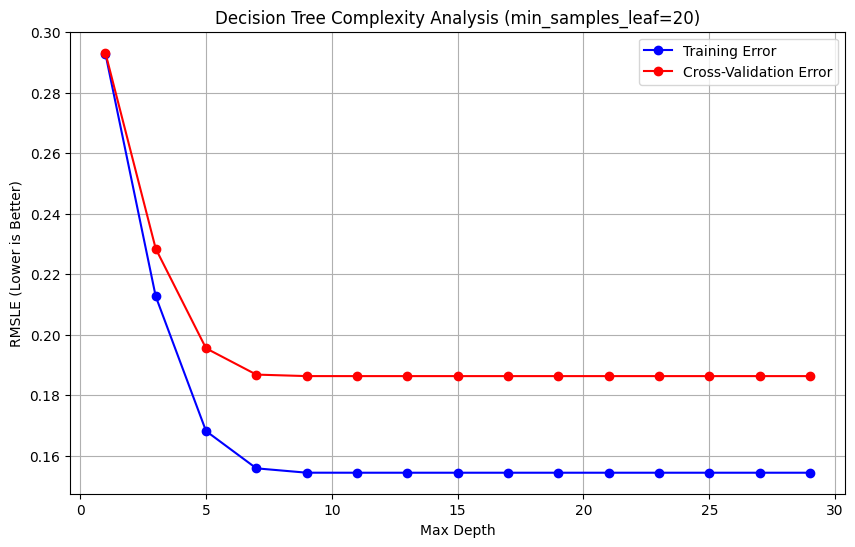

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.tree import DecisionTreeRegressor

# Grid Search for Best Parameters
# We tune both depth (complexity) and leaf size (smoothing)
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 5, 10, 20]
}

dt = DecisionTreeRegressor(random_state=0)

grid_search = GridSearchCV(
    dt,
    param_grid,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_processed, y)

# Convert negative RMSE to positive RMSLE
best_score = -grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best Decision Tree RMSLE: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Analyze: How does Depth affect Training vs CV Score?
# We will fix min_samples_leaf to the best value found above to isolate the effect of depth
best_leaf = best_params['min_samples_leaf']
depth_range = range(1, 31, 2)

train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(min_samples_leaf=best_leaf, random_state=0),
    X_processed, y,
    param_name="max_depth",
    param_range=depth_range,
    cv=kf,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

# Calculate mean and flip sign for plotting (Error minimization)
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_mean, label="Training Error", color="blue", marker='o')
plt.plot(depth_range, test_mean, label="Cross-Validation Error", color="red", marker='o')

plt.title(f"Decision Tree Complexity Analysis (min_samples_leaf={best_leaf})")
plt.xlabel("Max Depth")
plt.ylabel("RMSLE (Lower is Better)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

#### Comments:
    - Low Depth (1-5): Both Training and CV errors are high. The model is too simple to capture the complexity of house prices (Underfitting/High Bias).
    - Optimal Depth (~ 6-8): The CV error reaches its minimum (the "sweet spot"). The model captures patterns without memorizing noise.
    - High Depth (10+): CV Error starts to plateau. The model is Overfitting (High Variance), it fails to generalize to unseen test data. The model stops improving,
      but doesn't necessarily get drastically worse, it just fails to generalize better.

Since single trees are unstable (high variance), we will now fix this using Ensembles.